In [1]:
import itertools
from copy import deepcopy, copy

import numpy as np
import networkx as nx
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from scipy.stats import beta, dirichlet
import matplotlib.pyplot as plt
import pandas as pd


from model import BaseModel
from true_causal_model import TrueCausalModel
from agents.causal_agents import HalfBlindAgent

%matplotlib inline
np.random.seed(0)

In [2]:
def is_a_valid_edge(x, y, causal_order, invalid_edges):
    if tuple(sorted((x, y))) in invalid_edges or causal_order.index(y) < causal_order.index(x):
        return False
    return True

In [3]:
def create_pij(variables, causal_order, invalid_edges):
    connection_tables = dict()
    for pair in itertools.combinations((variables), 2):
        proba = np.random.rand()
        if is_a_valid_edge(pair[0], pair[1], causal_order, invalid_edges):
            connection_tables["{}->{}".format(pair[0], pair[1])] = proba
        elif is_a_valid_edge(pair[1], pair[0], causal_order, invalid_edges):
            connection_tables["{}->{}".format(pair[1], pair[0])] = proba
    return connection_tables
def create_ebunch_from_beliefs(variables, connection_tables):
    ebunch = []
    for pair in connection_tables:
        r = np.random.rand()
        if r <= connection_tables[pair]:
            ebunch.append((pair.split('->')[0], pair.split('->')[1]))
    nodes = []
    for v in variables:
        flag = False
        for edge in ebunch:
            if v in edge:
                flag = True
                break
        if not flag:
            nodes.append(v)
    return ebunch, nodes
def combine_tables_and_create_model(effect, incomplete_dag, complete_model, incomplete_model):
    new_pgmodel = BayesianModel()
    new_pgmodel.add_edges_from(incomplete_dag.edges)
    new_pgmodel.add_nodes_from(incomplete_dag.nodes)
    for cpd in complete_model.pgmodel.get_cpds():
        if cpd.variable != effect:
            new_pgmodel.add_cpds(cpd)
    for cpd in incomplete_model.pgmodel.get_cpds():
        if cpd.variable == effect:
            new_pgmodel.add_cpds(cpd)
            break
    model_without_edge = deepcopy(complete_model)
    model_without_edge.pgmodel = new_pgmodel
    model_without_edge.update_infer_system()
    return model_without_edge

In [4]:
def update_connection_beliefs(variables, connection_tables, model, nature_response):
    for pair in connection_tables:
        cause = pair.split("->")[0]
        effect = pair.split("->")[1]
        
        # Crea una copia del PGM y elimino la causa
        incomplete_model = deepcopy(model)
        incomplete_model.pgmodel.remove_nodes_from([cause])
        # Copia el DAG y elimino la arista causa -> efecto si está presente
        incomplete_dag = deepcopy(model.digraph)
        
        if incomplete_dag.has_edge(*(cause, effect)):
            incomplete_dag.remove_edge(cause, effect)

        # Crea un nuevo modelo sin la conexión
        model_without_ij = combine_tables_and_create_model(effect, incomplete_dag, model, incomplete_model)
        # Copia el modelo que tiene 
        model_with_ij = deepcopy(model)
        # Calcula las probabilidades de observación dados los modelos
        p_sub = model_with_ij.get_joint_prob_observation(nature_response)
        p_complement = model_without_ij.get_joint_prob_observation(nature_response)
#         if cause == "Enfermedad" and effect == "Reaccion":
        print(pair, p_sub, p_complement)
        # Actualiza probabilidad de conexión
        connection_tables[pair] = (connection_tables[pair] * p_sub) / (p_sub * connection_tables[pair] + p_complement * (1 - connection_tables[pair]))
    return connection_tables

In [5]:
def plot_probabilities(connection_probas):
    for pair in connection_probas:
        plt.plot(connection_probas[pair], label=pair)
    plt.legend()
    plt.show()

In [6]:
def print_dict(data):
    for k in data:
        print("{} : {}".format(k, data[k]))

In [7]:
def generate_data(intervention_vars, n_steps=100):
    data_dict = dict()
    for i in range(n_steps):
        best_actions = np.random.randint(2, size=1)
        obs = nature.action_simulator(intervention_vars, best_actions)
        for k in obs:
            if k not in data_dict:
                data_dict[k] = []
            data_dict[k].append(obs[k])
    return data_dict
def update_prob_measures(connection_probas, connection_tables):
    for k in connection_tables:
        if k not in connection_probas:
            connection_probas[k] = []
        connection_probas[k] += [connection_tables[k]]
def generate_approx_model_from_graph(ebunch, nodes, df):
    approx_model = BayesianModel(ebunch)
    approx_model.add_nodes_from(nodes)
    approx_model.fit(df)
    return approx_model

def training(rounds, agent, unknown_model, connection_tables, data, complete_model):
    intervention_vars = agent.model.get_intervention_variables()
    connection_probas = dict()
    update_prob_measures(connection_probas, connection_tables)
    local_data = deepcopy(data)
    for rnd in range(rounds):
#         unknown_model.show_graph()
        print_dict(connection_tables)
        best_actions = agent.make_decision(target, intervention_vars)
        nature_response = agent.nature.action_simulator(intervention_vars, best_actions)
        agent.rewards_per_round.append(nature_response[target["variable"]])
        connection_tables = update_connection_beliefs(variables, connection_tables, unknown_model, nature_response)
        update_prob_measures(connection_probas, connection_tables)
        
        for k in nature_response:
            local_data[k].append(nature_response[k])
        df = pd.DataFrame.from_dict(local_data)
        
        ebunch, nodes = create_ebunch_from_beliefs(variables, connection_tables)
        
        approx_model = generate_approx_model_from_graph(ebunch, nodes, df)
        unknown_model.reset(approx_model, ebunch, nodes)
        agent = HalfBlindAgent(nature, unknown_model)
    return connection_probas

## Aprendizaje

/home/ivan/Documentos/playing-against-nature/venv/lib/python3.7/site-packages/pgmpy/factors/discrete/CPD.py:504: UserWarning: Same ordering provided as current
  warn("Same ordering provided as current")


Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2828069625764096
Reaccion->Final : 0.29614019752214493
Tratamiento->Final : 0.11872771895424405
Tratamiento->Reaccion : 0.317983179393976


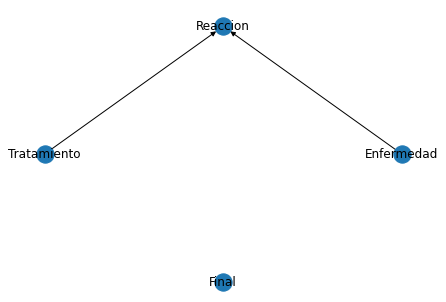

Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2828069625764096
Reaccion->Final : 0.29614019752214493
Tratamiento->Final : 0.11872771895424405
Tratamiento->Reaccion : 0.317983179393976
Enfermedad->Final 0.1406 0.1406
Enfermedad->Reaccion 0.1406 0.1406
Reaccion->Final 0.1406 0.1406
Tratamiento->Final 0.1406 0.1406
Tratamiento->Reaccion 0.1406 0.0703
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2828069625764096
Reaccion->Final : 0.29614019752214493
Tratamiento->Final : 0.11872771895424405
Tratamiento->Reaccion : 0.4825299508605085
Enfermedad->Final 0.2921953094963476 0.2921953094963476
Enfermedad->Reaccion 0.2921953094963476 0.2921953094963476
Reaccion->Final 0.2921953094963476 0.2921953094963476
Tratamiento->Final 0.2921953094963476 0.1460976547481738
Tratamiento->Reaccion 0.2921953094963476 0.1460976547481738
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2828069625764096
Reaccion->Final : 0.29614019752214493
Tratamiento->Final

Enfermedad->Final 0.08468223714155668 0.08468223714155668
Enfermedad->Reaccion 0.08468223714155668 0.07863350591715978
Reaccion->Final 0.08468223714155668 0.08468223714155668
Tratamiento->Final 0.08468223714155668 0.08468223714155668
Tratamiento->Reaccion 0.08468223714155668 0.08468223714155668
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2980768663750697
Reaccion->Final : 0.29614019752214493
Tratamiento->Final : 0.21225489802867759
Tratamiento->Reaccion : 0.6509547420346313
Enfermedad->Final 0.012815948736205056 0.012815948736205056
Enfermedad->Reaccion 0.012815948736205056 0.014044143823424704
Reaccion->Final 0.012815948736205056 0.036311854752580995
Tratamiento->Final 0.012815948736205056 0.012815948736205056
Tratamiento->Reaccion 0.012815948736205056 0.012815948736205056
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2792897085792051
Reaccion->Final : 0.1292957349746224
Tratamiento->Final : 0.21225489802867759
Tratamiento->Reaccion : 0.650954

Reaccion->Final 0.16206879032667784 0.16206879032667784
Tratamiento->Final 0.16206879032667784 0.16206879032667784
Tratamiento->Reaccion 0.16206879032667784 0.08103439516333892
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2792897085792051
Reaccion->Final : 0.12929573497462243
Tratamiento->Final : 0.2122548980286776
Tratamiento->Reaccion : 0.7885797538367367
Enfermedad->Final 0.09274776313093368 0.09274776313093368
Enfermedad->Reaccion 0.09274776313093368 0.09274776313093368
Reaccion->Final 0.09274776313093368 0.09274776313093368
Tratamiento->Final 0.09274776313093368 0.09274776313093368
Tratamiento->Reaccion 0.09274776313093368 0.09274776313093368
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920504
Reaccion->Final : 0.12929573497462243
Tratamiento->Final : 0.2122548980286776
Tratamiento->Reaccion : 0.7885797538367367
Enfermedad->Final 0.07908163265306123 0.07908163265306123
Enfermedad->Reaccion 0.07908163265306123 0.07908163265306123

Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920504
Reaccion->Final : 0.12929573497462243
Tratamiento->Final : 0.21225489802867759
Tratamiento->Reaccion : 0.8817943422932417
Enfermedad->Final 0.3102493074792244 0.3102493074792244
Enfermedad->Reaccion 0.3102493074792244 0.3102493074792244
Reaccion->Final 0.3102493074792244 0.3102493074792244
Tratamiento->Final 0.3102493074792244 0.15512465373961218
Tratamiento->Reaccion 0.3102493074792244 0.1551246537396122
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920504
Reaccion->Final : 0.12929573497462243
Tratamiento->Final : 0.35018195987302403
Tratamiento->Reaccion : 0.9371846035190502
Enfermedad->Final 0.3195600475624257 0.3195600475624257
Enfermedad->Reaccion 0.3195600475624257 0.3195600475624257
Reaccion->Final 0.3195600475624257 0.3195600475624257
Tratamiento->Final 0.3195600475624257 0.15978002378121284
Tratamiento->Reaccion 0.3195600475624257 0.15978002378121284


Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920504
Reaccion->Final : 0.12929573497462246
Tratamiento->Final : 0.518718173224528
Tratamiento->Reaccion : 0.9675738717069913
Enfermedad->Final 0.17674640542606593 0.17674640542606593
Enfermedad->Reaccion 0.17674640542606593 0.17674640542606593
Reaccion->Final 0.17674640542606593 0.17674640542606593
Tratamiento->Final 0.17674640542606593 0.17674640542606593
Tratamiento->Reaccion 0.17674640542606593 0.08837320271303296
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920504
Reaccion->Final : 0.12929573497462246
Tratamiento->Final : 0.518718173224528
Tratamiento->Reaccion : 0.9835197403465837
Enfermedad->Final 0.325 0.325
Enfermedad->Reaccion 0.325 0.325
Reaccion->Final 0.325 0.325
Tratamiento->Final 0.325 0.20073529411764707
Tratamiento->Reaccion 0.325 0.1625
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.12929573497462246
Trata

Enfermedad->Final 0.32141897339424885 0.32141897339424885
Enfermedad->Reaccion 0.32141897339424885 0.32141897339424885
Reaccion->Final 0.32141897339424885 0.32141897339424885
Tratamiento->Final 0.32141897339424885 0.1607094866971244
Tratamiento->Reaccion 0.32141897339424885 0.16070948669712443
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.12929573497462246
Tratamiento->Final : 0.777281332755606
Tratamiento->Reaccion : 0.9958283729640993
Enfermedad->Final 0.3301248699271592 0.3301248699271592
Enfermedad->Reaccion 0.3301248699271592 0.3301248699271592
Reaccion->Final 0.3301248699271592 0.3301248699271592
Tratamiento->Final 0.3301248699271592 0.16506243496357959
Tratamiento->Reaccion 0.3301248699271592 0.1650624349635796
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.12929573497462246
Tratamiento->Final : 0.8746857556315649
Tratamiento->Reaccion : 0.9979098267704726
Enfermedad->F

Tratamiento->Final 0.19349962207105065 0.19349962207105065
Tratamiento->Reaccion 0.19349962207105065 0.0967498110355253
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.12929573497462246
Tratamiento->Final : 0.8746857556315649
Tratamiento->Reaccion : 0.9989538200365597
Enfermedad->Final 0.098876953125 0.098876953125
Enfermedad->Reaccion 0.098876953125 0.098876953125
Reaccion->Final 0.098876953125 0.07415771484375
Tratamiento->Final 0.098876953125 0.07415771484375
Tratamiento->Reaccion 0.098876953125 0.0494384765625
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.1652713529495428
Tratamiento->Final : 0.9029746521872385
Tratamiento->Reaccion : 0.9994766362519465
Enfermedad->Final 0.33633136094674554 0.33633136094674554
Enfermedad->Reaccion 0.33633136094674554 0.33633136094674554


Reaccion->Final 0.33633136094674554 0.33633136094674554
Tratamiento->Final 0.33633136094674554 0.16816568047337277
Tratamiento->Reaccion 0.33633136094674554 0.16816568047337277
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.1652713529495428
Tratamiento->Final : 0.9490138517077763
Tratamiento->Reaccion : 0.9997382496306461
Enfermedad->Final 0.3213957759412305 0.3213957759412305
Enfermedad->Reaccion 0.3213957759412305 0.3213957759412305
Reaccion->Final 0.3213957759412305 0.3213957759412305
Tratamiento->Final 0.3213957759412305 0.19452902228021846
Tratamiento->Reaccion 0.3213957759412305 0.16069788797061524
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.1652713529495428
Tratamiento->Final : 0.9685061134132016
Tratamiento->Reaccion : 0.999869107684767
Enfermedad->Final 0.340833147694364 0.340833147694364
Enfermedad->Reaccion 0.340833147694364 0.340833147694364


Reaccion->Final 0.340833147694364 0.278347070617064
Tratamiento->Final 0.340833147694364 0.278347070617064
Tratamiento->Reaccion 0.340833147694364 0.17041657384718198
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.19513330172204718
Tratamiento->Final : 0.9741306259800142
Tratamiento->Reaccion : 0.9999345495589036
Enfermedad->Final 0.1003460207612457 0.1003460207612457
Enfermedad->Reaccion 0.1003460207612457 0.1003460207612457
Reaccion->Final 0.1003460207612457 0.1003460207612457
Tratamiento->Final 0.1003460207612457 0.06046490994587882
Tratamiento->Reaccion 0.1003460207612457 0.05017301038062285
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.19513330172204715
Tratamiento->Final : 0.9842501126867256
Tratamiento->Reaccion : 0.9999672737084767
Enfermedad->Final 0.028565427431211935 0.028565427431211935
Enfermedad->Reaccion 0.028565427431211935 0.02856542743121193
Reaccion->Final 0

Tratamiento->Reaccion 0.028565427431211935 0.014282713715605966
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.19513330172204715
Tratamiento->Final : 0.9551047042253654
Tratamiento->Reaccion : 0.9999836365864814
Enfermedad->Final 0.3183673469387755 0.3183673469387755
Enfermedad->Reaccion 0.3183673469387755 0.3183673469387755
Reaccion->Final 0.3183673469387755 0.195
Tratamiento->Final 0.3183673469387755 0.3183673469387755
Tratamiento->Reaccion 0.3183673469387755 0.15918367346938775
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.28357693337566836
Tratamiento->Final : 0.9551047042253653
Tratamiento->Reaccion : 0.9999918182262998
Enfermedad->Final 0.32592739535806386 0.32592739535806386
Enfermedad->Reaccion 0.32592739535806386 0.32592739535806386
Reaccion->Final 0.32592739535806386 0.24444554651854788


Tratamiento->Final 0.32592739535806386 0.2444455465185479
Tratamiento->Reaccion 0.32592739535806386 0.16296369767903193
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.3454488067488502
Tratamiento->Final : 0.9659463156108067
Tratamiento->Reaccion : 0.9999959090964146
Enfermedad->Final 0.03125 0.03125
Enfermedad->Reaccion 0.03125 0.03125
Reaccion->Final 0.03125 0.03125
Tratamiento->Final 0.03125 0.08506944444444445
Tratamiento->Reaccion 0.03125 0.015625
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.3454488067488502
Tratamiento->Final : 0.9124338823275588
Tratamiento->Reaccion : 0.9999979545440234
Enfermedad->Final 0.035653968849690375 0.035653968849690375
Enfermedad->Reaccion 0.035653968849690375 0.035653968849690375
Reaccion->Final 0.035653968849690375 0.054372302495777826
Tratamiento->Final 0.035653968849690375 0.05437230249577782


Tratamiento->Reaccion 0.035653968849690375 0.017826984424845187
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.2570993473410929
Tratamiento->Final : 0.8723309013884096
Tratamiento->Reaccion : 0.9999989772709658
Enfermedad->Final 0.17350403727321184 0.17350403727321184
Enfermedad->Reaccion 0.17350403727321184 0.17350403727321184
Reaccion->Final 0.17350403727321184 0.17350403727321184
Tratamiento->Final 0.17350403727321184 0.17350403727321184
Tratamiento->Reaccion 0.17350403727321184 0.08675201863660592
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.25709934734109297
Tratamiento->Final : 0.8723309013884097
Tratamiento->Reaccion : 0.9999994886352214
Enfermedad->Final 0.3128888888888889 0.3128888888888889
Enfermedad->Reaccion 0.3128888888888889 0.31288888888888894
Reaccion->Final 0.3128888888888889 0.3128888888888889
Tratamiento->Final 0.3128888888888889 0.19646511627906976
Tratami

Enfermedad->Final 0.038088642659279776 0.038088642659279776
Enfermedad->Reaccion 0.038088642659279776 0.038088642659279776
Reaccion->Final 0.038088642659279776 0.038088642659279776
Tratamiento->Final 0.038088642659279776 0.09349030470914127
Tratamiento->Reaccion 0.038088642659279776 0.019044321329639888
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920493
Reaccion->Final : 0.25709934734109297
Tratamiento->Final : 0.8159504676793128
Tratamiento->Reaccion : 0.9999998721587563
Enfermedad->Final 0.11688311688311687 0.11688311688311687
Enfermedad->Reaccion 0.11688311688311687 0.11688311688311687
Reaccion->Final 0.11688311688311687 0.08766233766233765
Tratamiento->Final 0.11688311688311687 0.08766233766233765
Tratamiento->Reaccion 0.11688311688311687 0.05844155844155843
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920493
Reaccion->Final : 0.31574025833872577
Tratamiento->Final : 0.8553050932818179
Tratamiento->Reaccion : 0.999999

Enfermedad->Final 0.3129520052596976 0.3129520052596976
Enfermedad->Reaccion 0.3129520052596976 0.3129520052596976
Reaccion->Final 0.3129520052596976 0.3129520052596976
Tratamiento->Final 0.3129520052596976 0.199151276074353
Tratamiento->Reaccion 0.3129520052596976 0.1564760026298488
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920493
Reaccion->Final : 0.31574025833872577
Tratamiento->Final : 0.9028075109476523
Tratamiento->Reaccion : 0.999999968039686
Enfermedad->Final 0.12337766383592375 0.12337766383592375
Enfermedad->Reaccion 0.12337766383592375 0.12337766383592375
Reaccion->Final 0.12337766383592375 0.12337766383592375
Tratamiento->Final 0.12337766383592375 0.12337766383592375
Tratamiento->Reaccion 0.12337766383592375 0.06168883191796187
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920493
Reaccion->Final : 0.31574025833872577
Tratamiento->Final : 0.9028075109476523
Tratamiento->Reaccion : 0.9999999840198428
Enfermedad

Enfermedad->Reaccion 0.28500000000000003 0.28500000000000003
Reaccion->Final 0.28500000000000003 0.24046875
Tratamiento->Final 0.28500000000000003 0.24046875000000004
Tratamiento->Reaccion 0.28500000000000003 0.14250000000000002
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920493
Reaccion->Final : 0.35353909765577246
Tratamiento->Final : 0.91672926073483
Tratamiento->Reaccion : 0.9999999920099214
Enfermedad->Final 0.1262002743484225 0.1262002743484225
Enfermedad->Reaccion 0.1262002743484225 0.1262002743484225
Reaccion->Final 0.1262002743484225 0.09465020576131687
Tratamiento->Final 0.1262002743484225 0.09465020576131686
Tratamiento->Reaccion 0.1262002743484225 0.06310013717421126
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.4216907420616115
Tratamiento->Final : 0.9362191764695419
Tratamiento->Reaccion : 0.9999999960049606


Enfermedad->Final 0.3191552647233789 0.3191552647233789
Enfermedad->Reaccion 0.3191552647233789 0.3191552647233789
Reaccion->Final 0.3191552647233789 0.3191552647233789
Tratamiento->Final 0.3191552647233789 0.20213166765813997
Tratamiento->Reaccion 0.3191552647233789 0.15957763236168945
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.4216907420616115
Tratamiento->Final : 0.9586381783806559
Tratamiento->Reaccion : 0.9999999980024803
Enfermedad->Final 0.32544636376832636 0.32544636376832636
Enfermedad->Reaccion 0.32544636376832636 0.32544636376832636
Reaccion->Final 0.32544636376832636 0.24408477282624477
Tratamiento->Final 0.32544636376832636 0.24408477282624474
Tratamiento->Reaccion 0.32544636376832636 0.16272318188416318
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.4929618412066516
Tratamiento->Final : 0.9686545071141633
Tratamiento->Reaccion : 0.9999999990012401


Enfermedad->Final 0.3316326530612245 0.3316326530612245
Enfermedad->Reaccion 0.3316326530612245 0.3316326530612245
Reaccion->Final 0.3316326530612245 0.3316326530612245
Tratamiento->Final 0.3316326530612245 0.2100340136054422
Tratamiento->Reaccion 0.3316326530612245 0.16581632653061226
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.4929618412066516
Tratamiento->Final : 0.9799170340007564
Tratamiento->Reaccion : 0.99999999950062
Enfermedad->Final 0.03986159169550173 0.03986159169550173
Enfermedad->Reaccion 0.03986159169550173 0.03986159169550173
Reaccion->Final 0.03986159169550173 0.05730103806228374
Tratamiento->Final 0.03986159169550173 0.057301038062283725
Tratamiento->Reaccion 0.03986159169550173 0.019930795847750864
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.4034621561155635
Tratamiento->Final : 0.9713821810507444
Tratamiento->Reaccion : 0.9999999997503101


Enfermedad->Final 0.32990805840995135 0.32990805840995135
Enfermedad->Reaccion 0.32990805840995135 0.32990805840995135
Reaccion->Final 0.32990805840995135 0.32990805840995135
Tratamiento->Final 0.32990805840995135 0.21157147224116443
Tratamiento->Reaccion 0.32990805840995135 0.16495402920497568
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.4034621561155636
Tratamiento->Final : 0.9814569219690085
Tratamiento->Reaccion : 0.999999999875155
Enfermedad->Final 0.27031311930241775 0.27031311930241775
Enfermedad->Reaccion 0.27031311930241775 0.27031311930241775
Reaccion->Final 0.27031311930241775 0.27031311930241775
Tratamiento->Final 0.27031311930241775 0.13515655965120887
Tratamiento->Reaccion 0.27031311930241775 0.13515655965120887
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.4034621561155636
Tratamiento->Final : 0.990641695095463
Tratamiento->Reaccion : 0.9999999999375775


Enfermedad->Final 0.33354855371900827 0.33354855371900827
Enfermedad->Reaccion 0.33354855371900827 0.33354855371900827
Reaccion->Final 0.33354855371900827 0.25016141528925623
Tratamiento->Final 0.33354855371900827 0.2501614152892562
Tratamiento->Reaccion 0.33354855371900827 0.16677427685950416
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.4741785130656984
Tratamiento->Final : 0.9929648119629193
Tratamiento->Reaccion : 0.9999999999687889
Enfermedad->Final 0.27471278878929434 0.27471278878929434
Enfermedad->Reaccion 0.27471278878929434 0.27471278878929434
Reaccion->Final 0.27471278878929434 0.27471278878929434
Tratamiento->Final 0.27471278878929434 0.13735639439464714
Tratamiento->Reaccion 0.27471278878929434 0.13735639439464717
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.47417851306569836
Tratamiento->Final : 0.9964699888353012
Tratamiento->Reaccion : 0.9999999999843944


Enfermedad->Final 0.3370370370370371 0.3370370370370371
Enfermedad->Reaccion 0.3370370370370371 0.3370370370370371
Reaccion->Final 0.3370370370370371 0.3370370370370371
Tratamiento->Final 0.3370370370370371 0.21415895061728396
Tratamiento->Reaccion 0.3370370370370371 0.1685185185185185
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.4741785130656984
Tratamiento->Final : 0.9977540816131151
Tratamiento->Reaccion : 0.9999999999921971
Enfermedad->Final 0.27895181741335584 0.27895181741335584
Enfermedad->Reaccion 0.27895181741335584 0.27895181741335584
Reaccion->Final 0.27895181741335584 0.27895181741335584
Tratamiento->Final 0.27895181741335584 0.13947590870667795
Tratamiento->Reaccion 0.27895181741335584 0.13947590870667792
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.47417851306569836
Tratamiento->Final : 0.998875778351522
Tratamiento->Reaccion : 0.9999999999960987
Enfermedad->F

Tratamiento->Final 0.34038279773156904 0.17019139886578452
Tratamiento->Reaccion 0.34038279773156904 0.17019139886578452
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.4741785130656984
Tratamiento->Final : 0.999437573029473
Tratamiento->Reaccion : 0.9999999999980493
Enfermedad->Final 0.03757659845068794 0.03757659845068794
Enfermedad->Reaccion 0.03757659845068794 0.03757659845068794
Reaccion->Final 0.03757659845068794 0.05419701699618453
Tratamiento->Final 0.03757659845068794 0.05419701699618453
Tratamiento->Reaccion 0.03757659845068794 0.01878829922534397
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.384705641424623
Tratamiento->Final : 0.9991890090008524
Tratamiento->Reaccion : 0.9999999999990247
Enfermedad->Final 0.3386147578089634 0.3386147578089634
Enfermedad->Reaccion 0.3386147578089634 0.3386147578089634
Reaccion->Final 0.3386147578089634 0.3386147578089634
Tratamiento-

Tratamiento->Reaccion 0.3386147578089634 0.1693073789044817
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.384705641424623
Tratamiento->Final : 0.999480814180736
Tratamiento->Reaccion : 0.9999999999995123
Enfermedad->Final 0.3440443213296399 0.3440443213296399
Enfermedad->Reaccion 0.3440443213296399 0.3440443213296399
Reaccion->Final 0.3440443213296399 0.3440443213296399
Tratamiento->Final 0.3440443213296399 0.22018836565096955
Tratamiento->Reaccion 0.3440443213296399 0.17202216066481996
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.384705641424623
Tratamiento->Final : 0.999667658958839
Tratamiento->Reaccion : 0.9999999999997562
Enfermedad->Final 0.03949652777777778 0.03949652777777778
Enfermedad->Reaccion 0.03949652777777778 0.03949652777777778
Reaccion->Final 0.03949652777777778 0.055013020833333336
Tratamiento->Final 0.03949652777777778 0.055013020833333336


Tratamiento->Reaccion 0.03949652777777778 0.01974826388888889
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.3098160446651673
Tratamiento->Final : 0.9995371568369389
Tratamiento->Reaccion : 0.9999999999998781
Enfermedad->Final 0.34222552874907003 0.34222552874907003
Enfermedad->Reaccion 0.34222552874907003 0.34222552874907003
Reaccion->Final 0.34222552874907003 0.2566691465618025
Tratamiento->Final 0.34222552874907003 0.2566691465618025
Tratamiento->Reaccion 0.34222552874907003 0.17111276437453501
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.3744208626513072
Tratamiento->Final : 0.9996528274560945
Tratamiento->Reaccion : 0.999999999999939
Enfermedad->Final 0.34745939192003333 0.34745939192003333
Enfermedad->Reaccion 0.34745939192003333 0.34745939192003333
Reaccion->Final 0.34745939192003333 0.34745939192003333
Tratamiento->Final 0.34745939192003333 0.22482666536002158
Tratami

Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.37442086265130725
Tratamiento->Final : 0.999775331413203
Tratamiento->Reaccion : 0.9999999999999695
Enfermedad->Final 0.3526170798898072 0.3526170798898072
Enfermedad->Reaccion 0.3526170798898072 0.3526170798898072
Reaccion->Final 0.3526170798898072 0.2644628099173554
Tratamiento->Final 0.3526170798898072 0.2644628099173554
Tratamiento->Reaccion 0.3526170798898072 0.1763085399449036
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.4438342197269632
Tratamiento->Final : 0.9998314890951254
Tratamiento->Reaccion : 0.9999999999999847
Enfermedad->Final 0.0405 0.0405
Enfermedad->Reaccion 0.0405 0.04050000000000001
Reaccion->Final 0.0405 0.0405
Tratamiento->Final 0.0405 0.08910000000000001
Tratamiento->Reaccion 0.0405 0.020250000000000004


Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920493
Reaccion->Final : 0.44383421972696313
Tratamiento->Final : 0.9996293509593622
Tratamiento->Reaccion : 0.9999999999999923
Enfermedad->Final 0.04391726301343007 0.04391726301343007
Enfermedad->Reaccion 0.04391726301343007 0.04391726301343007
Reaccion->Final 0.04391726301343007 0.057641407705126955
Tratamiento->Final 0.04391726301343007 0.05764140770512696
Tratamiento->Reaccion 0.04391726301343007 0.021958631506715034
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.378116831420322
Tratamiento->Final : 0.9995135794751945
Tratamiento->Reaccion : 0.9999999999999962
Enfermedad->Final 0.2525951557093426 0.2525951557093426
Enfermedad->Reaccion 0.2525951557093426 0.2525951557093426
Reaccion->Final 0.2525951557093426 0.2525951557093426
Tratamiento->Final 0.2525951557093426 0.1262975778546713
Tratamiento->Reaccion 0.2525951557093426 0.1262975778546713
Enfermedad

Enfermedad->Final 0.04646997832029409 0.04646997832029409
Enfermedad->Reaccion 0.04646997832029409 0.04646997832029409
Reaccion->Final 0.04646997832029409 0.04646997832029409
Tratamiento->Final 0.04646997832029409 0.09704024884532
Tratamiento->Reaccion 0.04646997832029409 0.023234989160147046
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.378116831420322
Tratamiento->Final : 0.9994921306448978
Tratamiento->Reaccion : 0.999999999999999
Enfermedad->Final 0.04992603550295858 0.04992603550295858
Enfermedad->Reaccion 0.04992603550295858 0.04992603550295858
Reaccion->Final 0.04992603550295858 0.06310096153846154
Tratamiento->Final 0.04992603550295858 0.06310096153846154
Tratamiento->Reaccion 0.04992603550295858 0.02496301775147929
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.3248124851468511
Tratamiento->Final : 0.9993581955804005
Tratamiento->Reaccion : 0.9999999999999994


Enfermedad->Final 0.24834467120181405 0.24834467120181405
Enfermedad->Reaccion 0.24834467120181405 0.24834467120181405
Reaccion->Final 0.24834467120181405 0.24834467120181405
Tratamiento->Final 0.24834467120181405 0.12417233560090703
Tratamiento->Reaccion 0.24834467120181405 0.12417233560090703
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.3248124851468511
Tratamiento->Final : 0.9996789947789154
Tratamiento->Reaccion : 0.9999999999999998
Enfermedad->Final 0.32707369170523315 0.32707369170523315
Enfermedad->Reaccion 0.32707369170523315 0.32707369170523315
Reaccion->Final 0.32707369170523315 0.32707369170523315
Tratamiento->Final 0.32707369170523315 0.21804912780348878
Tratamiento->Reaccion 0.32707369170523315 0.16353684585261657
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.3248124851468511
Tratamiento->Final : 0.9997859736180815
Tratamiento->Reaccion : 0.9999999999999998
Enfe

Reaccion->Final 0.05144554109529217 0.05144554109529217
Tratamiento->Final 0.05144554109529217 0.10289108219058432
Tratamiento->Reaccion 0.05144554109529217 0.025722770547646084
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.3248124851468511
Tratamiento->Final : 0.9995720388311436
Tratamiento->Reaccion : 0.9999999999999999
Enfermedad->Final 0.32578875171467764 0.32578875171467764
Enfermedad->Reaccion 0.32578875171467764 0.32578875171467764
Reaccion->Final 0.32578875171467764 0.32578875171467764
Tratamiento->Final 0.32578875171467764 0.21906485029090392
Tratamiento->Reaccion 0.32578875171467764 0.16289437585733882
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.3248124851468511
Tratamiento->Final : 0.9997121926582352
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.24627556602979547 0.24627556602979547
Enfermedad->Reaccion 0.24627556602979547 0.24627556602979547
Reaccion->Final 0.

Tratamiento->Reaccion 0.24627556602979547 0.12313778301489774
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.32481248514685107
Tratamiento->Final : 0.9998560756178707
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.3287603305785124 0.3287603305785124
Enfermedad->Reaccion 0.3287603305785124 0.3287603305785124
Reaccion->Final 0.3287603305785124 0.3287603305785124
Tratamiento->Final 0.3287603305785124 0.22010225521781762
Tratamiento->Reaccion 0.3287603305785124 0.1643801652892562
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.32481248514685107
Tratamiento->Final : 0.999903639262153
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.2500608716824933 0.2500608716824933
Enfermedad->Reaccion 0.2500608716824933 0.2500608716824933
Reaccion->Final 0.2500608716824933 0.2500608716824933
Tratamiento->Final 0.2500608716824933 0.12503043584124665
Tratamiento->Reaccion 0.2500608716824933 0.125030

Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.32481248514685107
Tratamiento->Final : 0.9999518173096167
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.0510204081632653 0.0510204081632653
Enfermedad->Reaccion 0.0510204081632653 0.0510204081632653
Reaccion->Final 0.0510204081632653 0.0510204081632653
Tratamiento->Final 0.0510204081632653 0.1020408163265306
Tratamiento->Reaccion 0.0510204081632653 0.02551020408163265
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.32481248514685107
Tratamiento->Final : 0.999903639262153
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.3257890202834991 0.3257890202834991
Enfermedad->Reaccion 0.3257890202834991 0.3257890202834991
Reaccion->Final 0.3257890202834991 0.3257890202834991
Tratamiento->Final 0.3257890202834991 0.21897294805940107
Tratamiento->Reaccion 0.3257890202834991 0.16289451014174955
Enfermedad->Final : 0.039187792254320675
Enfermeda

Enfermedad->Final 0.3303324099722992 0.3303324099722992
Enfermedad->Reaccion 0.3303324099722992 0.3303324099722992
Reaccion->Final 0.3303324099722992 0.24774930747922438
Tratamiento->Final 0.3303324099722992 0.24774930747922438
Tratamiento->Reaccion 0.3303324099722992 0.1651662049861496
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.3907738996985926
Tratamiento->Final : 0.9999514223887168
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.334820415879017 0.334820415879017
Enfermedad->Reaccion 0.334820415879017 0.334820415879017
Reaccion->Final 0.334820415879017 0.25111531190926273
Tratamiento->Final 0.334820415879017 0.25111531190926273
Tratamiento->Reaccion 0.334820415879017 0.1674102079395085
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.460984909354562
Tratamiento->Final : 0.9999635663490727
Tratamiento->Reaccion : 1.0


Enfermedad->Final 0.33925386444708683 0.33925386444708683
Enfermedad->Reaccion 0.33925386444708683 0.33925386444708683
Reaccion->Final 0.33925386444708683 0.33925386444708683
Tratamiento->Final 0.33925386444708683 0.22802308921853376
Tratamiento->Reaccion 0.33925386444708683 0.16962693222354341
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.460984909354562
Tratamiento->Final : 0.9999755115158668
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.24545255314486084 0.24545255314486084
Enfermedad->Reaccion 0.24545255314486084 0.24545255314486084
Reaccion->Final 0.24545255314486084 0.2163050624589086
Tratamiento->Final 0.24545255314486084 0.2163050624589086
Tratamiento->Reaccion 0.24545255314486084 0.12272627657243042
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.4925094766268589
Tratamiento->Final : 0.9999784194606013
Tratamiento->Reaccion : 1.0


Enfermedad->Final 0.25028727377190463 0.25028727377190463
Enfermedad->Reaccion 0.25028727377190463 0.25028727377190463
Reaccion->Final 0.25028727377190463 0.21976443550703822
Tratamiento->Final 0.25028727377190463 0.21976443550703822
Tratamiento->Reaccion 0.25028727377190463 0.12514363688595231
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.5250013302695529
Tratamiento->Final : 0.9999810511838297
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.3400889767671775 0.3400889767671775
Enfermedad->Reaccion 0.3400889767671775 0.3400889767671775
Reaccion->Final 0.3400889767671775 0.2550667325753831
Tratamiento->Final 0.3400889767671775 0.2550667325753831
Tratamiento->Reaccion 0.3400889767671775 0.17004448838358874
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.5957459655533311
Tratamiento->Final : 0.9999857883205486
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.344375 0.344375


Enfermedad->Reaccion 0.344375 0.344375
Reaccion->Final 0.344375 0.344375
Tratamiento->Final 0.344375 0.2295833333333333
Tratamiento->Reaccion 0.344375 0.1721875
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.5957459655533311
Tratamiento->Final : 0.9999905255021495
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.047332832456799395 0.047332832456799395
Enfermedad->Reaccion 0.047332832456799395 0.047332832456799395
Reaccion->Final 0.047332832456799395 0.05916604057099925
Tratamiento->Final 0.047332832456799395 0.05916604057099925
Tratamiento->Reaccion 0.047332832456799395 0.023666416228399698
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.5410641265411731
Tratamiento->Final : 0.9999881569057387
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.24832034399355013 0.24832034399355013


Enfermedad->Reaccion 0.24832034399355013 0.24832034399355013
Reaccion->Final 0.24832034399355013 0.21875839828003227
Tratamiento->Final 0.24832034399355013 0.21875839828003227
Tratamiento->Reaccion 0.24832034399355013 0.12416017199677506
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.5723337062290488
Tratamiento->Final : 0.9999895667832029
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.2529578954326129 0.2529578954326129
Enfermedad->Reaccion 0.2529578954326129 0.2529578954326129
Reaccion->Final 0.2529578954326129 0.2220735012228171
Tratamiento->Final 0.2529578954326129 0.22207350122281708
Tratamiento->Reaccion 0.2529578954326129 0.12647894771630644
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.6038645356838647
Tratamiento->Final : 0.9999908405945166
Tratamiento->Reaccion : 1.0


Enfermedad->Final 0.25754422476586886 0.25754422476586886
Enfermedad->Reaccion 0.25754422476586886 0.25754422476586886
Reaccion->Final 0.25754422476586886 0.22535119667013526
Tratamiento->Final 0.25754422476586886 0.22535119667013526
Tratamiento->Reaccion 0.25754422476586886 0.12877211238293443
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.6353238228798144
Tratamiento->Final : 0.999991985511026
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.12620800000000001 0.12620800000000001
Enfermedad->Reaccion 0.12620800000000001 0.12620800000000001
Reaccion->Final 0.12620800000000001 0.09465600000000002
Tratamiento->Final 0.12620800000000001 0.09465600000000002
Tratamiento->Reaccion 0.12620800000000001 0.06310400000000001
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.6990560993562619
Tratamiento->Final : 0.999993989121226
Tratamiento->Reaccion : 1.0


Enfermedad->Final 0.33818342151675485 0.33818342151675485
Enfermedad->Reaccion 0.33818342151675485 0.33818342151675485
Reaccion->Final 0.33818342151675485 0.33818342151675485
Tratamiento->Final 0.33818342151675485 0.224614362052173
Tratamiento->Reaccion 0.33818342151675485 0.16909171075837742
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.6990560993562619
Tratamiento->Final : 0.9999960076918599
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.1302002604005208 0.1302002604005208
Enfermedad->Reaccion 0.1302002604005208 0.1302002604005208
Reaccion->Final 0.1302002604005208 0.1302002604005208
Tratamiento->Final 0.1302002604005208 0.08647629235556979
Tratamiento->Reaccion 0.1302002604005208 0.0651001302002604
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.6990560993562619
Tratamiento->Final : 0.9999973483887997
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.252685546875 0.2526855468

Enfermedad->Reaccion 0.252685546875 0.252685546875
Reaccion->Final 0.252685546875 0.22039794921875
Tratamiento->Final 0.252685546875 0.22039794921875
Tratamiento->Reaccion 0.252685546875 0.1263427734375
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.7270126003485907
Tratamiento->Final : 0.9999976872050028
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.34090499369028304 0.34090499369028304
Enfermedad->Reaccion 0.34090499369028304 0.34090499369028304
Reaccion->Final 0.34090499369028304 0.2556787452677123
Tratamiento->Final 0.34090499369028304 0.2556787452677123
Tratamiento->Reaccion 0.34090499369028304 0.17045249684514152
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.7802630989555469
Tratamiento->Final : 0.9999982654027492
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.13207100591715976 0.13207100591715976


Enfermedad->Reaccion 0.13207100591715976 0.13207100591715976
Reaccion->Final 0.13207100591715976 0.13207100591715976
Tratamiento->Final 0.13207100591715976 0.08739993038635573
Tratamiento->Reaccion 0.13207100591715976 0.06603550295857988
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.7802630989555469
Tratamiento->Final : 0.999998852104087
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.3450847852689237 0.3450847852689237
Enfermedad->Reaccion 0.3450847852689237 0.3450847852689237
Reaccion->Final 0.3450847852689237 0.2588135889516928
Tratamiento->Final 0.3450847852689237 0.2588135889516928
Tratamiento->Reaccion 0.3450847852689237 0.17254239263446186
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.8256177716002112
Tratamiento->Final : 0.9999991390778182
Tratamiento->Reaccion : 1.0


Enfermedad->Final 0.2508034894398531 0.2508034894398531
Enfermedad->Reaccion 0.2508034894398531 0.2508034894398531
Reaccion->Final 0.2508034894398531 0.21808999081726355
Tratamiento->Final 0.2508034894398531 0.21808999081726355
Tratamiento->Reaccion 0.2508034894398531 0.12540174471992654
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.8448339489896827
Tratamiento->Final : 0.9999992513719317
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.2550737746622195 0.2550737746622195
Enfermedad->Reaccion 0.2550737746622195 0.2550737746622195
Reaccion->Final 0.2550737746622195 0.2211543897337328
Tratamiento->Final 0.2550737746622195 0.22115438973373283
Tratamiento->Reaccion 0.2550737746622195 0.12753688733110974
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.8626333384303861
Tratamiento->Final : 0.9999993509234719
Tratamiento->Reaccion : 1.0
Enfermedad->Final 

0.34573401648474045 0.34573401648474045
Enfermedad->Reaccion 0.34573401648474045 0.34573401648474045
Reaccion->Final 0.34573401648474045 0.25930051236355534
Tratamiento->Final 0.34573401648474045 0.2593005123635554
Tratamiento->Reaccion 0.34573401648474045 0.17286700824237025
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.8933111303605374
Tratamiento->Final : 0.999999513192525
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.13196159122085047 0.13196159122085047
Enfermedad->Reaccion 0.13196159122085047 0.13196159122085047
Reaccion->Final 0.13196159122085047 0.09897119341563786
Tratamiento->Final 0.13196159122085047 0.09897119341563786
Tratamiento->Reaccion 0.13196159122085047 0.06598079561042523
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.9177906418979805
Tratamiento->Final : 0.9999996348943494
Tratamiento->Reaccion : 1.0


Enfermedad->Final 0.34969723183391005 0.34969723183391005
Enfermedad->Reaccion 0.34969723183391005 0.34969723183391005
Reaccion->Final 0.34969723183391005 0.26227292387543255
Tratamiento->Final 0.34969723183391005 0.26227292387543255
Tratamiento->Reaccion 0.34969723183391005 0.17484861591695502
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.279289708579205
Reaccion->Final : 0.93704919510794
Tratamiento->Final : 0.9999997261707371
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.04454153124833502 0.04454153124833502
Enfermedad->Reaccion 0.04454153124833502 0.04454153124833502
Reaccion->Final 0.04454153124833502 0.05770152911716128
Tratamiento->Final 0.04454153124833502 0.05770152911716128
Tratamiento->Reaccion 0.04454153124833502 0.02227076562416751
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920493
Reaccion->Final : 0.9199391534689919
Tratamiento->Final : 0.9999996452666654
Tratamiento->Reaccion : 1.0


Enfermedad->Final 0.24952741020793948 0.24952741020793948
Enfermedad->Reaccion 0.24952741020793948 0.24952741020793948
Reaccion->Final 0.24952741020793948 0.21703686200378072
Tratamiento->Final 0.24952741020793948 0.21703686200378072
Tratamiento->Reaccion 0.24952741020793948 0.12476370510396974
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920493
Reaccion->Final : 0.9296301662384991
Tratamiento->Final : 0.9999996914558874
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.13524144713006572 0.13524144713006572
Enfermedad->Reaccion 0.13524144713006572 0.13524144713006572
Reaccion->Final 0.13524144713006572 0.1014310853475493
Tratamiento->Final 0.13524144713006572 0.1014310853475493
Tratamiento->Reaccion 0.13524144713006572 0.06762072356503286


Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920493
Reaccion->Final : 0.9462775140779776
Tratamiento->Final : 0.9999997685918978
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.046938775510204075 0.046938775510204075
Enfermedad->Reaccion 0.046938775510204075 0.046938775510204075
Reaccion->Final 0.046938775510204075 0.06020408163265306
Tratamiento->Final 0.046938775510204075 0.06020408163265305
Tratamiento->Reaccion 0.046938775510204075 0.02346938775510204
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920493
Reaccion->Final : 0.9321255719493712
Tratamiento->Final : 0.9999997031939752
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.34203510889794275 0.34203510889794275
Enfermedad->Reaccion 0.34203510889794275 0.34203510889794275
Reaccion->Final 0.34203510889794275 0.25652633167345706
Tratamiento->Final 0.34203510889794275 0.25652633167345706
Tratamiento->Reaccion 0.34203510889794275 0.17101755444897138


Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920493
Reaccion->Final : 0.9482154675820949
Tratamiento->Final : 0.999999777395465
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.34561594921642536 0.34561594921642536
Enfermedad->Reaccion 0.34561594921642536 0.34561594921642536
Reaccion->Final 0.34561594921642536 0.259211961912319
Tratamiento->Final 0.34561594921642536 0.259211961912319
Tratamiento->Reaccion 0.34561594921642536 0.17280797460821268
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.27928970857920493
Reaccion->Final : 0.9606521988150626
Tratamiento->Final : 0.9999998330465895
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.34916132818230716 0.34916132818230716
Enfermedad->Reaccion 0.34916132818230716 0.3491613281823072
Reaccion->Final 0.34916132818230716 0.2618709961367304
Tratamiento->Final 0.34916132818230716 0.2618709961367304
Tratamiento->Reaccion 0.34916132818230716 0.1745806640911536


Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2792897085792049
Reaccion->Final : 0.9701959683331628
Tratamiento->Final : 0.9999998747849369
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.14038387345679013 0.14038387345679013
Enfermedad->Reaccion 0.14038387345679013 0.14038387345679013
Reaccion->Final 0.14038387345679013 0.10528790509259259
Tratamiento->Final 0.14038387345679013 0.10528790509259259
Tratamiento->Reaccion 0.14038387345679013 0.07019193672839506
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2792897085792049
Reaccion->Final : 0.977479173392529
Tratamiento->Final : 0.9999999060886997
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.24004756242568373 0.24004756242568373
Enfermedad->Reaccion 0.24004756242568373 0.24004756242568373
Reaccion->Final 0.24004756242568373 0.20942925089179548
Tratamiento->Final 0.24004756242568373 0.20942925089179548
Tratamiento->Reaccion 0.24004756242568373 0.12002378121284187


Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2792897085792049
Reaccion->Final : 0.9802951244795896
Tratamiento->Final : 0.9999999180671809
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.1418652655282417 0.1418652655282417
Enfermedad->Reaccion 0.1418652655282417 0.1418652655282417
Reaccion->Final 0.1418652655282417 0.10639894914618127
Tratamiento->Final 0.1418652655282417 0.10639894914618125
Tratamiento->Reaccion 0.1418652655282417 0.07093263276412085
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2792897085792049
Reaccion->Final : 0.9851481800438202
Tratamiento->Final : 0.9999999385503844
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.14526354759590912 0.14526354759590912
Enfermedad->Reaccion 0.14526354759590912 0.14526354759590912
Reaccion->Final 0.14526354759590912 0.10894766069693185
Tratamiento->Final 0.14526354759590912 0.10894766069693183
Tratamiento->Reaccion 0.14526354759590912 0.07263177379795456
Enfermedad->Final : 0.03918779225432067

Enfermedad->Final 0.048210372534696865 0.048210372534696865
Enfermedad->Reaccion 0.048210372534696865 0.048210372534696865
Reaccion->Final 0.048210372534696865 0.06126734842951059
Tratamiento->Final 0.048210372534696865 0.06126734842951059
Tratamiento->Reaccion 0.048210372534696865 0.024105186267348432
Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2792897085792049
Reaccion->Final : 0.9858344973779598
Tratamiento->Final : 0.9999999414308349
Tratamiento->Reaccion : 1.0
Enfermedad->Final 0.14999324354758795 0.14999324354758795
Enfermedad->Reaccion 0.14999324354758795 0.14999324354758795
Reaccion->Final 0.14999324354758795 0.11249493266069097
Tratamiento->Final 0.14999324354758795 0.11249493266069097
Tratamiento->Reaccion 0.14999324354758795 0.07499662177379397


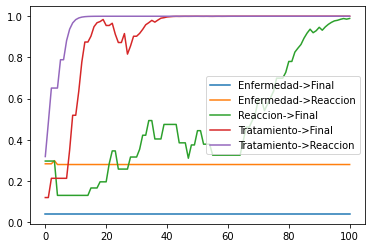

In [8]:
DG = nx.DiGraph([("Reaccion", "Final"), ("Tratamiento", "Reaccion"), ("Tratamiento", "Final"), ("Enfermedad", "Final")])
causal_order = list(nx.topological_sort(DG))
invalid_edges = sorted([("Enfermedad", "Tratamiento")])


COMPLETE_MODEL = BaseModel('configs/model_parameters.json')
nature = TrueCausalModel(COMPLETE_MODEL)
variables = sorted(["Tratamiento", "Reaccion", "Enfermedad", "Final"])
intervention_vars = COMPLETE_MODEL.get_intervention_variables()
target_value = 1
target = {
    "variable": COMPLETE_MODEL.get_target_variable(),
    "value" : target_value
}
rounds = 100

data = generate_data(intervention_vars, n_steps=50)
df = pd.DataFrame.from_dict(data)
connection_tables = create_pij(variables, causal_order, invalid_edges)
print_dict(connection_tables)
ebunch, nodes = create_ebunch_from_beliefs(variables, connection_tables)
approx_model = generate_approx_model_from_graph(ebunch, nodes, df)

unknown_model = BaseModel('configs/incomplete_params.json')
unknown_model.reset(approx_model, ebunch, nodes)
unknown_model.show_graph()
agent = HalfBlindAgent(nature, unknown_model)

connection_probas = training(rounds, agent, unknown_model, connection_tables, data, COMPLETE_MODEL)
plot_probabilities(connection_probas)

In [9]:
print_dict(connection_tables)

Enfermedad->Final : 0.039187792254320675
Enfermedad->Reaccion : 0.2792897085792049
Reaccion->Final : 0.9893381152945321
Tratamiento->Final : 0.9999999560731255
Tratamiento->Reaccion : 1.0
